Loading BVBRC subsystems data...
Loaded 363 subsystems with 2572 genes
Figures will be saved to: BVBRC_Visualizations

Creating hierarchical breakdown visualization...
Creating heatmap visualization...
Creating scatter plot of Gene Count vs Role Count...
Creating bar chart of top subsystems by class...
Creating treemap visualization...
All visualizations have been saved to the BVBRC_Visualizations directory.


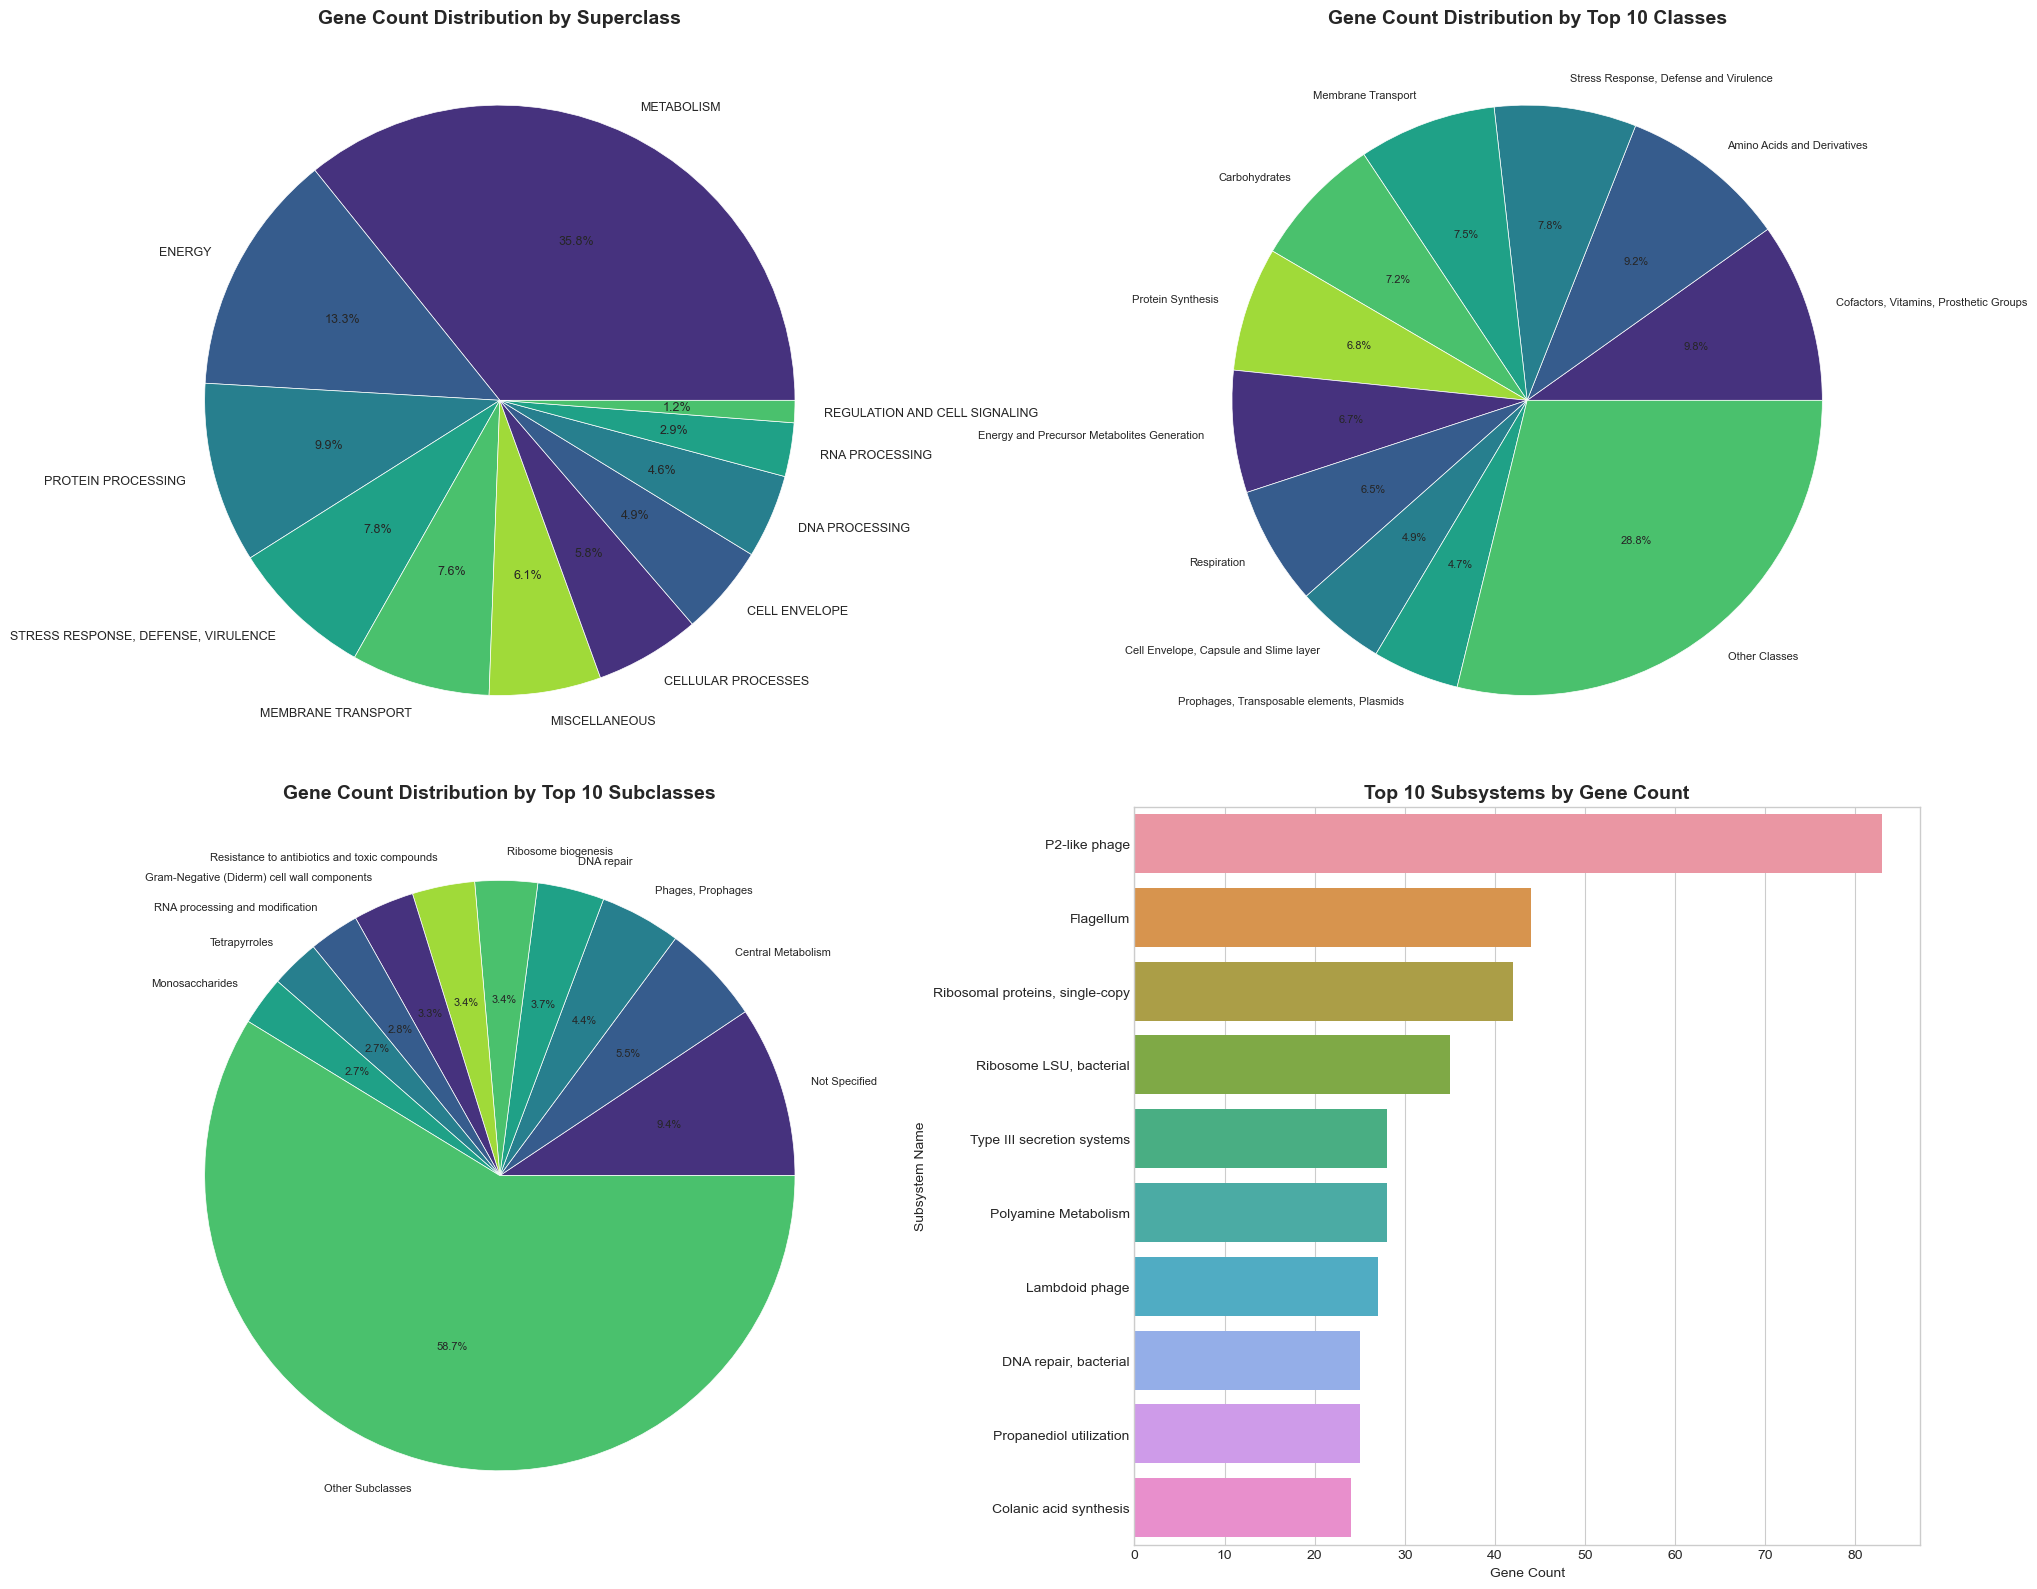

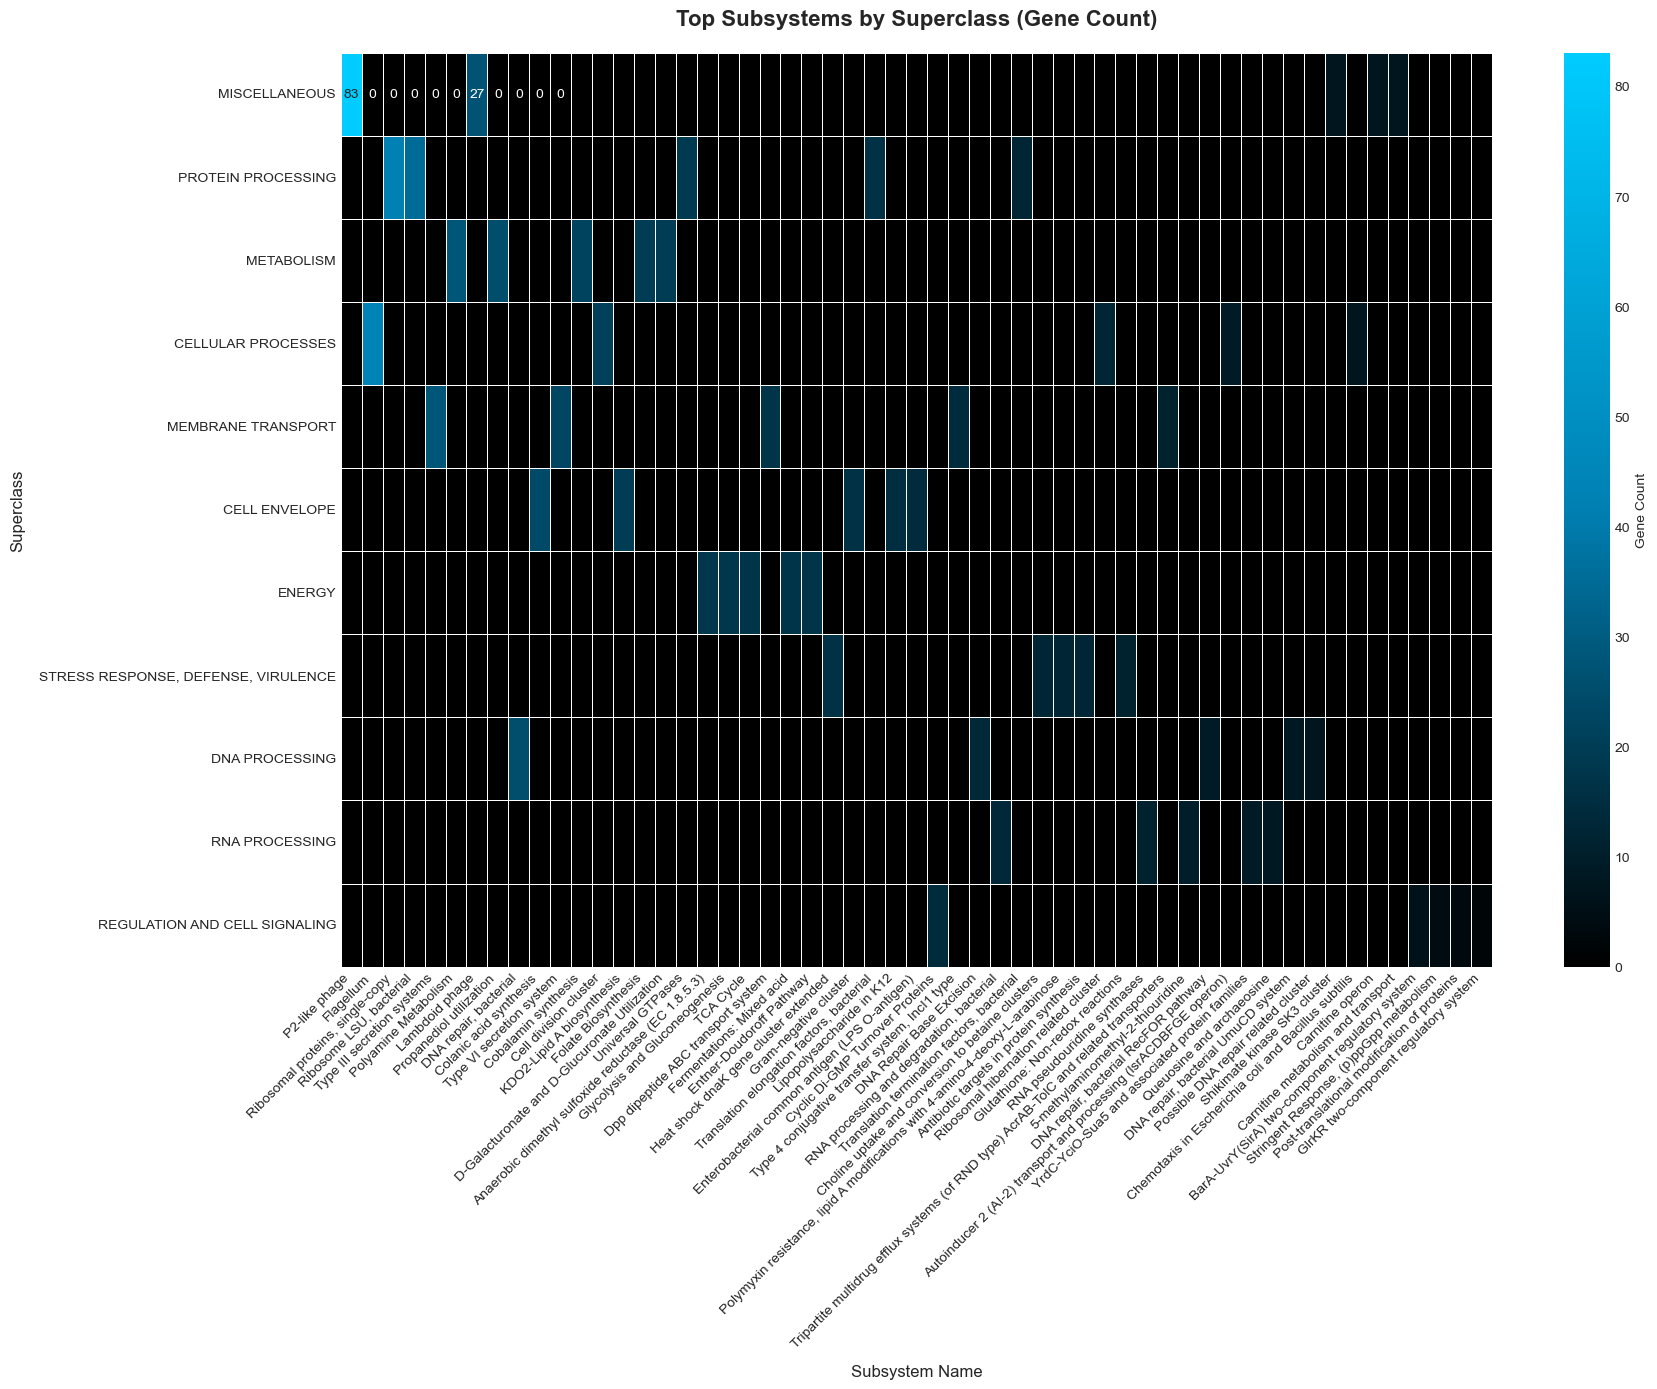

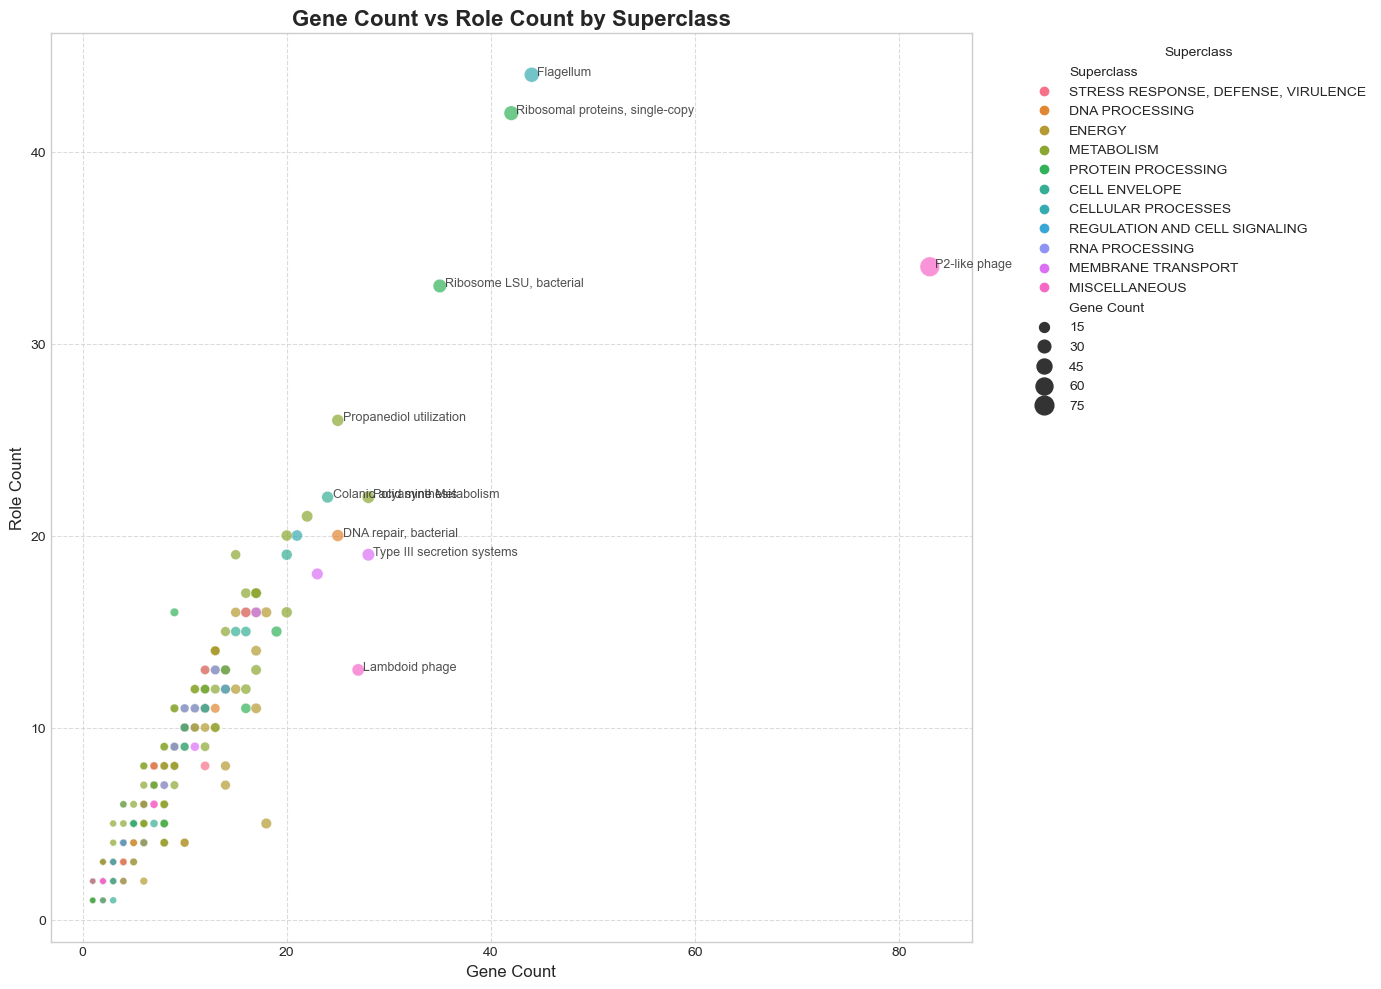

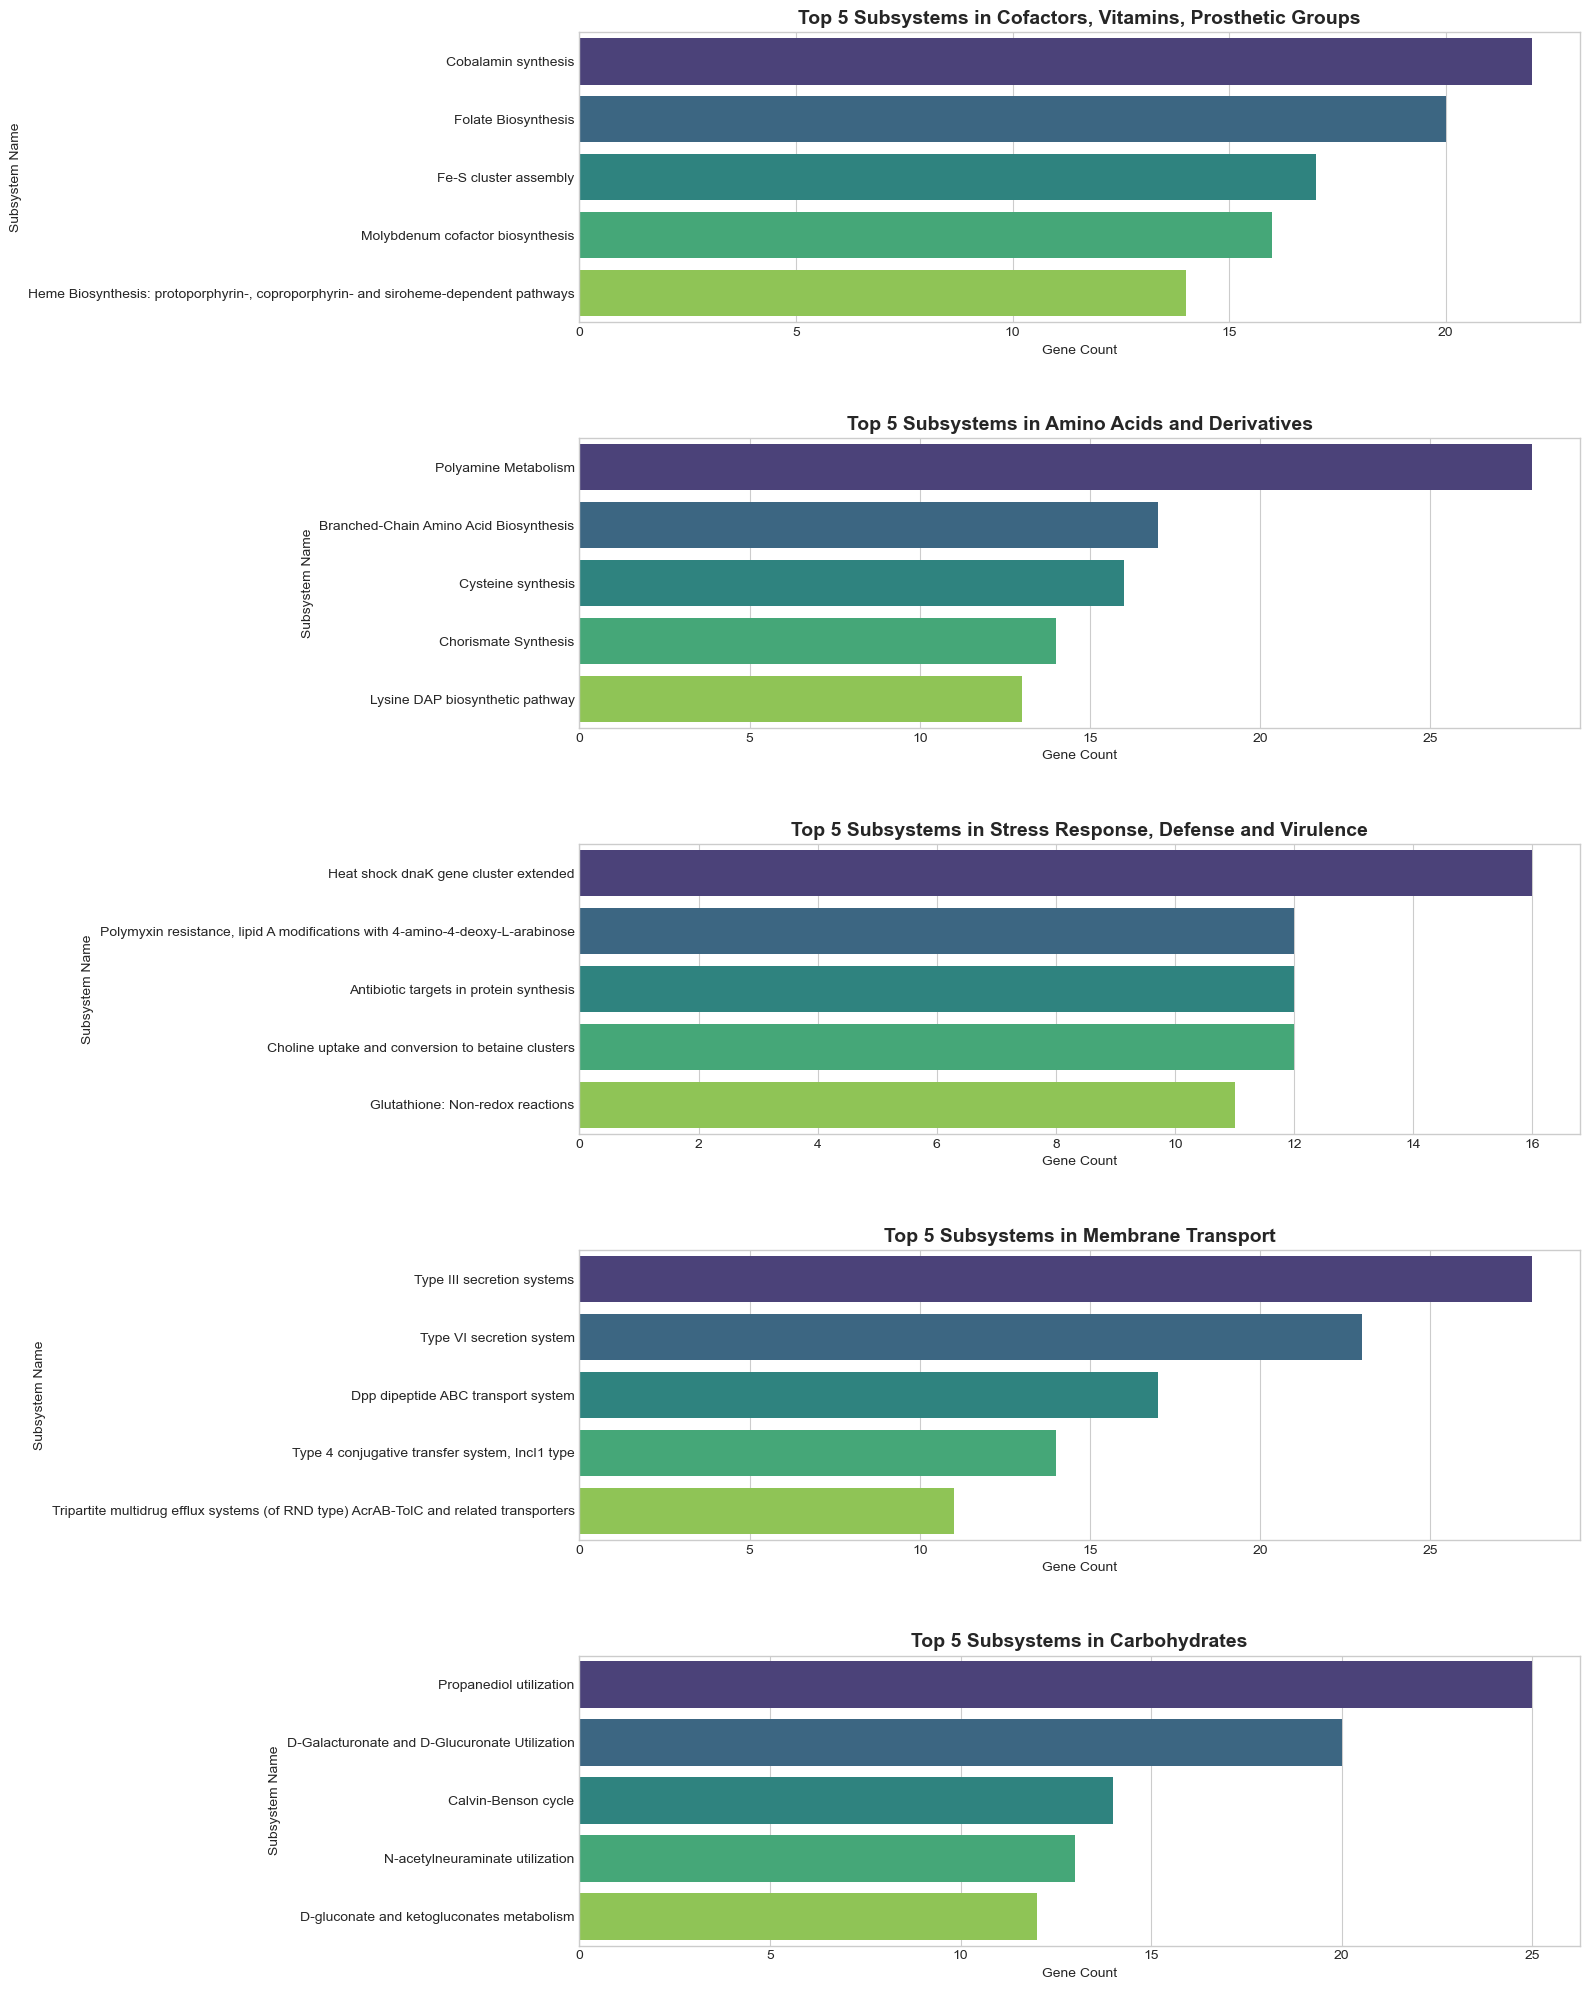

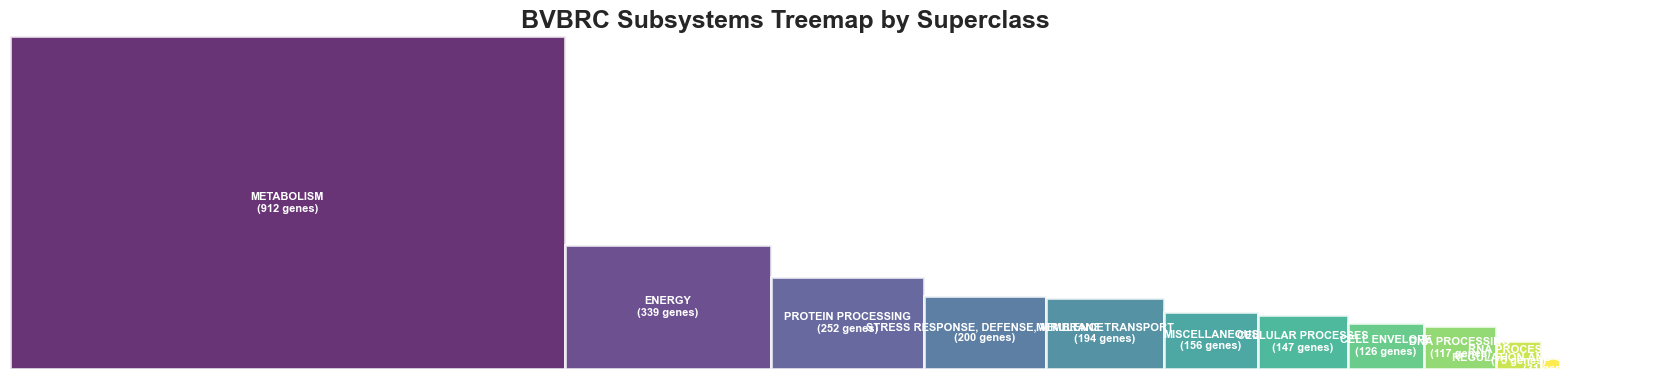

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.colors import LinearSegmentedColormap

# Set the style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Read the data
print("Loading BVBRC subsystems data...")
df = pd.read_csv('Datasets/BVBRC_subsystems.csv')
print(f"Loaded {len(df)} subsystems with {df['Gene Count'].sum()} genes")

# Replace NaN values with "Not Specified" for better visualization
df['Subclass'] = df['Subclass'].fillna('Not Specified')

# Create a directory for saving visualizations
output_dir = 'BVBRC_Visualizations'
os.makedirs(output_dir, exist_ok=True)
print(f"Figures will be saved to: {output_dir}")

# 1. Hierarchical Sunburst-like visualization (using multiple pie charts)
print("\nCreating hierarchical breakdown visualization...")
plt.figure(figsize=(20, 16))

# Superclass distribution pie chart
plt.subplot(2, 2, 1)
superclass_counts = df.groupby('Superclass')['Gene Count'].sum().sort_values(ascending=False)
plt.pie(superclass_counts, labels=superclass_counts.index, autopct='%1.1f%%', 
        textprops={'fontsize': 9}, wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})
plt.title('Gene Count Distribution by Superclass', fontsize=14, fontweight='bold')

# Class distribution pie chart
plt.subplot(2, 2, 2)
class_counts = df.groupby('Class')['Gene Count'].sum().sort_values(ascending=False).head(10)
other_classes = df.groupby('Class')['Gene Count'].sum().sort_values(ascending=False)[10:].sum()
class_counts['Other Classes'] = other_classes
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
        textprops={'fontsize': 8}, wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})
plt.title('Gene Count Distribution by Top 10 Classes', fontsize=14, fontweight='bold')

# Subclass distribution pie chart
plt.subplot(2, 2, 3)
subclass_counts = df.groupby('Subclass')['Gene Count'].sum().sort_values(ascending=False).head(10)
other_subclasses = df.groupby('Subclass')['Gene Count'].sum().sort_values(ascending=False)[10:].sum()
subclass_counts['Other Subclasses'] = other_subclasses
plt.pie(subclass_counts, labels=subclass_counts.index, autopct='%1.1f%%',
        textprops={'fontsize': 8}, wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})
plt.title('Gene Count Distribution by Top 10 Subclasses', fontsize=14, fontweight='bold')

# Top subsystems bar chart
plt.subplot(2, 2, 4)
top_subsystems = df.sort_values('Gene Count', ascending=False).head(10)
sns.barplot(x='Gene Count', y='Subsystem Name', data=top_subsystems)
plt.title('Top 10 Subsystems by Gene Count', fontsize=14, fontweight='bold')
plt.xlabel('Gene Count')
plt.ylabel('Subsystem Name')
plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'BVBRC_Hierarchical_Distribution.png'), dpi=300, bbox_inches='tight')

# 2. Heatmap visualization of top subsystems grouped by superclass
print("Creating heatmap visualization...")
plt.figure(figsize=(18, 14))

# Get top subsystems within each superclass
top_per_superclass = {}
for superclass in df['Superclass'].unique():
    superclass_df = df[df['Superclass'] == superclass]
    top_per_superclass[superclass] = superclass_df.nlargest(5, 'Gene Count')

# Combine top subsystems into a single dataframe
top_subsystems_df = pd.concat(top_per_superclass.values())

# Create a pivot table for the heatmap
pivot_df = top_subsystems_df.pivot_table(
    index='Superclass', 
    columns='Subsystem Name', 
    values='Gene Count',
    aggfunc='sum'
).fillna(0)

# Sort rows by total gene count
row_sums = pivot_df.sum(axis=1)
pivot_df = pivot_df.loc[row_sums.sort_values(ascending=False).index]

# Sort columns by total gene count
col_sums = pivot_df.sum(axis=0)
pivot_df = pivot_df[col_sums.sort_values(ascending=False).index]

# Create custom colormap
colors = [(0, 0, 0), (0, 0.5, 0.7), (0, 0.8, 1)]
positions = [0, 0.5, 1]
cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(positions, colors)))

# Create the heatmap
ax = sns.heatmap(pivot_df, annot=True, fmt='g', cmap=cmap, linewidths=0.5, 
                 cbar_kws={'label': 'Gene Count'})
plt.title('Top Subsystems by Superclass (Gene Count)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Subsystem Name', fontsize=12, labelpad=10)
plt.ylabel('Superclass', fontsize=12, labelpad=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'BVBRC_Superclass_Heatmap.png'), dpi=300, bbox_inches='tight')

# 3. Create a scatter plot of Gene Count vs Role Count
print("Creating scatter plot of Gene Count vs Role Count...")
plt.figure(figsize=(14, 10))

# Add superclass information via color
sns.scatterplot(data=df, x='Gene Count', y='Role Count', hue='Superclass', 
                size='Gene Count', sizes=(20, 200), alpha=0.7)

# Add labels for top 10 subsystems
top10 = df.nlargest(10, 'Gene Count')
for _, row in top10.iterrows():
    plt.text(row['Gene Count']+0.5, row['Role Count'], row['Subsystem Name'], 
             fontsize=9, alpha=0.8)

plt.title('Gene Count vs Role Count by Superclass', fontsize=16, fontweight='bold')
plt.xlabel('Gene Count', fontsize=12)
plt.ylabel('Role Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Superclass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'BVBRC_GeneCount_vs_RoleCount.png'), dpi=300, bbox_inches='tight')

# 4. Create a horizontal bar chart of top subsystems for each class
print("Creating bar chart of top subsystems by class...")
plt.figure(figsize=(16, 20))

# Get top 3 classes by gene count
top_classes = df.groupby('Class')['Gene Count'].sum().nlargest(5).index

# Plot top 5 subsystems for each class
for i, class_name in enumerate(top_classes):
    plt.subplot(5, 1, i+1)
    class_df = df[df['Class'] == class_name]
    top_subsystems = class_df.nlargest(5, 'Gene Count')
    
    # Create horizontal bar chart
    sns.barplot(x='Gene Count', y='Subsystem Name', data=top_subsystems, palette='viridis')
    plt.title(f'Top 5 Subsystems in {class_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Gene Count')
    plt.ylabel('Subsystem Name')
    plt.tight_layout()

plt.subplots_adjust(hspace=0.4)
plt.savefig(os.path.join(output_dir, 'BVBRC_TopSubsystems_ByClass.png'), dpi=300, bbox_inches='tight')

# 5. Create a treemap-like visualization (using nested rectangles)
print("Creating treemap visualization...")
from matplotlib.patches import Rectangle

plt.figure(figsize=(20, 16))
plt.subplot(111, aspect='equal')

# Group data by superclass and calculate total gene count
superclass_gene_counts = df.groupby('Superclass')['Gene Count'].sum().sort_values(ascending=False)
total_genes = superclass_gene_counts.sum()

# Calculate rectangle sizes
rects = []
colors = plt.cm.viridis(np.linspace(0, 1, len(superclass_gene_counts)))


current_x = 0
current_y = 0
row_height = 0
max_width = 100  # arbitrary width
for i, (superclass, gene_count) in enumerate(superclass_gene_counts.items()):
    width = max_width * gene_count / total_genes
    height = width * 0.6  # aspect ratio
    
    # Start a new row if this rectangle would exceed max width
    if current_x + width > max_width and i > 0:
        current_x = 0
        current_y += row_height
        row_height = 0
    
    # Create rectangle
    rect = Rectangle((current_x, current_y), width, height, facecolor=colors[i], alpha=0.8,
                    edgecolor='white', linewidth=2)
    plt.gca().add_patch(rect)
    
    # Add text label
    label_size = min(12, max(8, int(width / 10)))
    plt.text(current_x + width/2, current_y + height/2, 
             f"{superclass}\n({gene_count} genes)",
             ha='center', va='center', fontsize=label_size, 
             color='white', fontweight='bold', wrap=True)
    
    # Update position
    current_x += width
    row_height = max(row_height, height)
    
    # Store rectangle info
    rects.append((rect, superclass, gene_count))

plt.xlim(0, max_width)
plt.ylim(0, current_y + row_height)
plt.axis('off')
plt.title('BVBRC Subsystems Treemap by Superclass', fontsize=18, fontweight='bold')

plt.savefig(os.path.join(output_dir, 'BVBRC_Treemap.png'), dpi=300, bbox_inches='tight')

print(f"All visualizations have been saved to the {output_dir} directory.")